## 简单的作物生长模型与灌溉决策
在这个版本中，simulate_day 方法现在会收集每天的数据，并将其存储在 daily_data 列表中。新增加的 plot_growth 方法利用这些数据创建了四个子图，分别展示了LAI、生物量、土壤湿度以及累积有效温度随时间的变化趋势。这样可以直观地看到作物生长过程中各个因素的变化。

为了实现作物耗水和绘图功能的增强，我们可以在现有的CropGrowthModel类中添加新的方法来记录每天的土壤湿度、LAI（叶面积指数）、生物量等关键指标，并使用这些数据来生成图表。这将帮助更好地可视化作物在不同生长阶段的变化情况。

首先，我们需要引入matplotlib.pyplot模块来支持绘图功能。然后，在CropGrowthModel类中添加一个列表来存储每天的数据，并在每次调用simulate_day方法时更新这个列表。最后，我们将添加一个新的方法来绘制这些数据。


下面是修改后的代码：

第 1 天:
当前处于 播种 阶段，土壤湿度适宜，无需灌溉。
第 1 天: LAI=0.13, 生物量=25.01 g/m^2, 土壤湿度=19.95%, 累积有效温度=20.00

第 2 天:
当前处于 播种 阶段，土壤湿度适宜，无需灌溉。
第 2 天: LAI=0.16, 生物量=49.38 g/m^2, 土壤湿度=24.91%, 累积有效温度=40.00

第 3 天:
当前处于 播种 阶段，土壤湿度适宜，无需灌溉。
第 3 天: LAI=0.19, 生物量=73.15 g/m^2, 土壤湿度=29.86%, 累积有效温度=60.00

第 4 天:
当前处于 播种 阶段，土壤湿度适宜，无需灌溉。
第 4 天: LAI=0.22, 生物量=96.32 g/m^2, 土壤湿度=34.82%, 累积有效温度=80.00

第 5 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 5 天: LAI=0.25, 生物量=118.91 g/m^2, 土壤湿度=39.77%, 累积有效温度=100.00

第 6 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 6 天: LAI=0.27, 生物量=140.94 g/m^2, 土壤湿度=44.71%, 累积有效温度=120.00

第 7 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 7 天: LAI=0.30, 生物量=162.42 g/m^2, 土壤湿度=49.65%, 累积有效温度=140.00

第 8 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 8 天: LAI=0.33, 生物量=183.36 g/m^2, 土壤湿度=54.59%, 累积有效温度=160.00

第 9 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 9 天: LAI=0.36, 生物量=203.77 g/m^2, 土壤湿度=59.53%, 累积有效温度=180.00

第 10 天:
当前处于 分蘖 阶段，土壤湿度适宜，无需灌溉。
第 10 天: LAI=0.39, 生物量=223.68 g/m^2, 土壤湿度=64.47%, 累积有效温度=200.00

第 11 天:
当前处于 分蘖 阶段，土壤湿度适宜，无需灌溉。
第 11 天: LAI=0.41, 生物量=243.09 g/m^2

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15856\2471169579.py:218: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()
C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


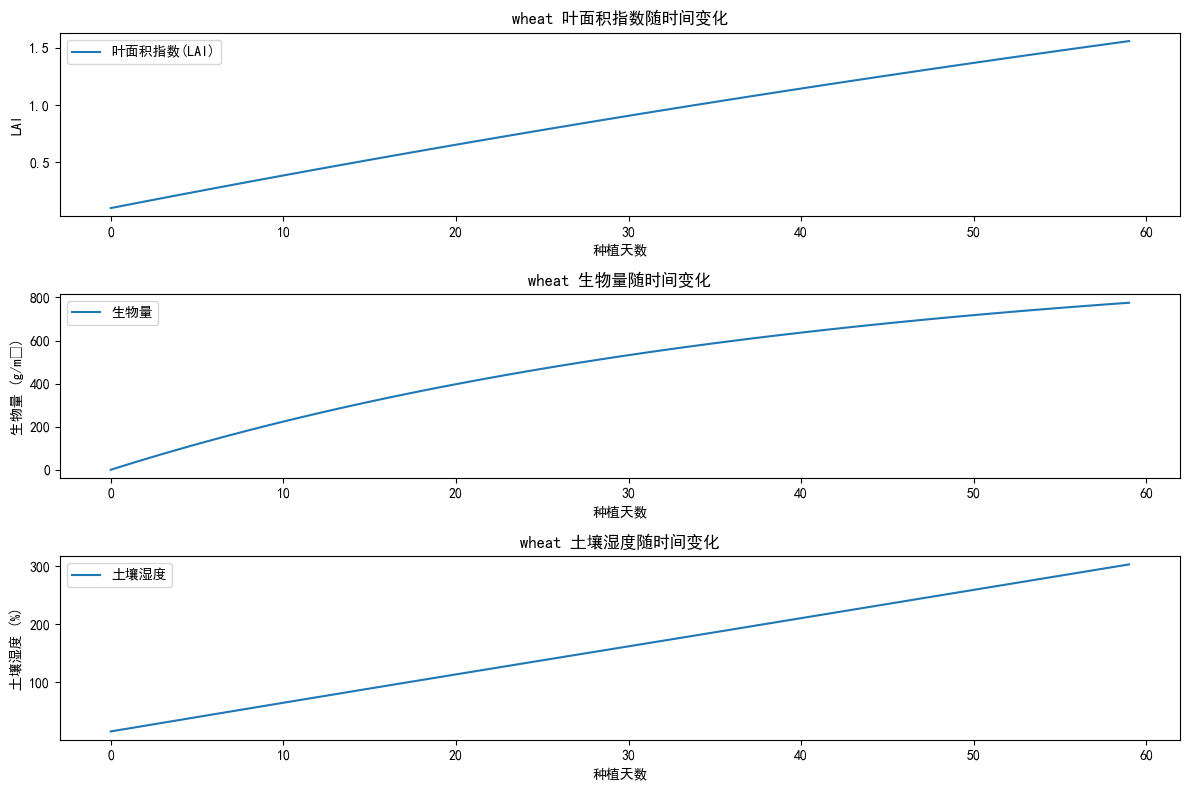

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class CropGrowthModel:
    def __init__(self, crop_type, soil_type, initial_soil_moisture, initial_lai=0.1, initial_biomass=0.01):
        """
        初始化作物生长模型。

        :param crop_type: 作物类型
        :param soil_type: 土壤类型
        :param initial_soil_moisture: 初始土壤湿度
        :param initial_lai: 初始叶面积指数
        :param initial_biomass: 初始生物量
        """
        self.crop_type = crop_type
        self.soil_type = soil_type
        self.soil_moisture = initial_soil_moisture
        self.lai = initial_lai
        self.biomass = initial_biomass
        self.days_since_planting = 0
        self.temperature = 0
        self.rainfall = 0
        self.sunlight = 0
        self.wind_speed = 2  # 默认风速为2 m/s
        self.net_radiation = 15  # 默认净辐射量为15 MJ/m²/day
        self.soil_heat_flux = 0  # 默认土壤热通量为0 MJ/m²/day
        self.irrigation = 0
        self.cumulative_temperature = 0  # 累积有效温度
        self.growth_stage = 0  # 当前生长阶段索引

        # 根据作物类型和土壤类型设定生长参数
        self.growth_parameters = {
            'wheat': {
                'soil_moisture_optimal_range': [(10, 20), (20, 30), (25, 35), (30, 40), (35, 45), (40, 50), (45, 55), (50, 60)],
                'growth_stages': ['播种', '出苗', '分蘖', '拔节', '抽穗', '开花', '灌浆', '成熟'],
                'days_to_next_stage': [10, 15, 20, 25, 30, 35, 40, 45],
                'lai_max': 5,
                'biomass_max': 1000,
                'base_temperature': 5,  # 基础温度
                'effective_temperature_thresholds': [100, 200, 300, 400, 500, 600, 700, 800]  # 积温阈值
            },
            'corn': {
                'soil_moisture_optimal_range': [(15, 25), (25, 35), (30, 40), (35, 45), (40, 50), (45, 55), (50, 60), (55, 65)],
                'growth_stages': ['播种', '出苗', '分蘖', '拔节', '抽穗', '开花', '灌浆', '成熟'],
                'days_to_next_stage': [12, 18, 22, 27, 32, 37, 42, 47],
                'lai_max': 6,
                'biomass_max': 1200,
                'base_temperature': 10,  # 基础温度
                'effective_temperature_thresholds': [150, 250, 350, 450, 550, 650, 750, 850]  # 积温阈值
            }
        }
        self.lai_history = [self.lai]
        self.biomass_history = [self.biomass]
        self.soil_moisture_history = [self.soil_moisture]
        self.days_history = [self.days_since_planting]
        self.evapotranspiration_history = []  # 记录每日耗水量历史

    def set_driving_variables(self, temperature, rainfall, sunlight):
        """
        设置驱动变量，并随机生成每天的变化量。

        :param temperature: 温度 (°C)
        :param rainfall: 降雨量 (mm)
        :param sunlight: 光照强度 (W/m²)
        """
        self.temperature = temperature + np.random.normal(0, 2)  # 温度随机变化
        self.rainfall = rainfall + np.random.normal(0, 1)  # 降雨量随机变化
        self.sunlight = sunlight + np.random.normal(0, 50)  # 光照强度随机变化
        self.wind_speed = 2 + np.random.normal(0, 0.5)  # 风速随机变化
        self.net_radiation = 15 + np.random.normal(0, 2)  # 净辐射量随机变化

    def update_soil_moisture(self):
        """更新土壤湿度"""
        # 计算作物的耗水量
        evapotranspiration = self.calculate_evapotranspiration()
        self.evapotranspiration_history.append(evapotranspiration)
        new_soil_moisture = self.soil_moisture + self.rainfall + self.irrigation - evapotranspiration
        max_field_capacity = self.get_max_field_capacity()
        self.soil_moisture = min(new_soil_moisture, max_field_capacity)
        self.irrigation = 0  # 重置灌溉量

    def calculate_evapotranspiration(self):
        """计算作物的蒸腾作用（耗水量）"""
        # 计算饱和水汽压和实际水汽压
        es = 0.6108 * np.exp((17.27 * self.temperature) / (self.temperature + 237.3))  # kPa
        ea = 0.6108 * np.exp((17.27 * (self.temperature - 10)) / ((self.temperature - 10) + 237.3))  # kPa

        # 计算饱和水汽压随温度的变化率
        delta = 4098 * (0.6108 * np.exp((17.27 * self.temperature) / (self.temperature + 237.3))) / (self.temperature + 237.3)**2  # kPa/°C

        # 心理常数
        gamma = 0.067  # kPa/°C

        # Penman-Monteith 公式
        et0 = (0.408 * delta * (self.net_radiation - self.soil_heat_flux) +
               gamma * (900 / (self.temperature + 273)) * self.wind_speed * (es - ea)) / \
              (delta + gamma * (1 + 0.34 * self.wind_speed))

        # 获取当前生长阶段的作物系数
        kc = self.get_crop_coefficient()

        # 考虑 LAI 对蒸腾作用的影响
        lai_effect = self.lai / self.growth_parameters[self.crop_type]['lai_max']

        # 综合考虑作物系数和 LAI 效应
        return et0 * kc * lai_effect

    def get_crop_coefficient(self):
        """获取当前生长阶段的作物系数"""
        growth_stage = self.growth_stage
        if self.crop_type == 'wheat':
            if growth_stage == 0:
                return 0.3
            elif growth_stage == 1:
                return 0.4
            elif growth_stage == 2:
                return 0.6
            elif growth_stage == 3:
                return 0.8
            elif growth_stage == 4:
                return 1.0
            elif growth_stage == 5:
                return 1.1
            elif growth_stage == 6:
                return 1.0
            elif growth_stage == 7:
                return 0.8
        elif self.crop_type == 'corn':
            if growth_stage == 0:
                return 0.4
            elif growth_stage == 1:
                return 0.5
            elif growth_stage == 2:
                return 0.7
            elif growth_stage == 3:
                return 0.9
            elif growth_stage == 4:
                return 1.1
            elif growth_stage == 5:
                return 1.2
            elif growth_stage == 6:
                return 1.1
            elif growth_stage == 7:
                return 0.9

    def update_cumulative_temperature(self):
        """更新累积有效温度"""
        base_temperature = self.growth_parameters[self.crop_type]['base_temperature']
        effective_temperature = max(0, self.temperature - base_temperature)
        self.cumulative_temperature += effective_temperature

    def update_growth_stage(self):
        """更新生长阶段"""
        thresholds = self.growth_parameters[self.crop_type]['effective_temperature_thresholds']
        if self.cumulative_temperature >= thresholds[self.growth_stage]:
            if self.growth_stage < len(thresholds) - 1:
                self.growth_stage += 1
            else:
                print(f"{self.crop_type} 已经成熟，无需再进行生长阶段更新。")

    def needs_irrigation(self):
        """判断是否需要灌溉"""
        min_moisture, max_moisture = self.get_soil_moisture_limits()
        if self.soil_moisture < min_moisture:
            return True
        return False

    def calculate_lai_increase_rate(self):
        """计算叶面积指数的增加率"""
        lai_max = self.growth_parameters[self.crop_type]['lai_max']
        lai_increase_rate = (lai_max - self.lai) * 0.01 * self.sunlight / 1000
        return lai_increase_rate

    def calculate_biomass_increase_rate(self):
        """计算生物量的增加率"""
        biomass_max = self.growth_parameters[self.crop_type]['biomass_max']
        biomass_increase_rate = (biomass_max - self.biomass) * 0.01 * self.temperature / 10
        return biomass_increase_rate

    def update_lai_and_biomass(self):
        """更新叶面积指数和生物量"""
        lai_increase_rate = self.calculate_lai_increase_rate()
        biomass_increase_rate = self.calculate_biomass_increase_rate()

        self.lai += lai_increase_rate
        self.biomass += biomass_increase_rate
        self.lai_history.append(self.lai)
        self.biomass_history.append(self.biomass)
        self.soil_moisture_history.append(self.soil_moisture)
        self.days_history.append(self.days_since_planting)

    def simulate_day(self):
        """模拟一天的生长过程"""
        self.days_since_planting += 1
        self.update_cumulative_temperature()
        self.update_soil_moisture()
        self.update_growth_stage()
        self.update_lai_and_biomass()

        if self.needs_irrigation():
            print(f"当前处于 {self.growth_parameters[self.crop_type]['growth_stages'][self.growth_stage]} 阶段，土壤湿度低于最佳范围，需要灌溉。")
            self.irrigate()
        else:
            print(f"当前处于 {self.growth_parameters[self.crop_type]['growth_stages'][self.growth_stage]} 阶段，土壤湿度适宜，无需灌溉。")

        print(f"第 {self.days_since_planting} 天: LAI={self.lai:.2f}, 生物量={self.biomass:.2f} g/m^2, 土壤湿度={self.soil_moisture:.2f}%, 累积有效温度={self.cumulative_temperature:.2f}")

    def irrigate(self):
        """执行灌溉操作"""
        min_moisture, max_moisture = self.get_soil_moisture_limits()
        self.irrigation = max_moisture - self.soil_moisture
        self.soil_moisture = max_moisture
        print(f"已灌溉，当前土壤湿度为 {self.soil_moisture:.2f}%。")

    def get_soil_moisture_limits(self):
        """获取土壤湿度的最小和最大限制"""
        field_capacity = self.get_max_field_capacity()
        min_moisture = 0.6 * field_capacity
        max_moisture = 0.8 * field_capacity
        return min_moisture, max_moisture

    def get_max_field_capacity(self):
        """获取土壤的最大田间持水量"""
        field_capacity = {
            'clay': 45,  # 黏土
            'loam': 35,  # 壤土
            'sand': 20   # 沙土
        }
        return field_capacity.get(self.soil_type, 35)  # 默认值为壤土

    def plot_growth(self):
        """绘制作物生长相关指标随时间变化曲线"""
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(self.days_history, self.lai_history, label='叶面积指数(LAI)')
        plt.xlabel('种植天数')
        plt.ylabel('LAI')
        plt.title(f'{self.crop_type} 叶面积指数随时间变化')
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(self.days_history, self.biomass_history, label='生物量')
        plt.xlabel('种植天数')
        plt.ylabel('生物量 (g/m²)')
        plt.title(f'{self.crop_type} 生物量随时间变化')
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(self.days_history, self.soil_moisture_history, label='土壤湿度')
        min_moisture, max_moisture = self.get_soil_moisture_limits()
        plt.axhline(y=min_moisture, color='r', linestyle='--', label='最低含水量')
        plt.axhline(y=max_moisture, color='g', linestyle='--', label='最高含水量')
        plt.xlabel('种植天数')
        plt.ylabel('土壤湿度 (%)')
        plt.title(f'{self.crop_type} 土壤湿度随时间变化')
        plt.legend()

        plt.tight_layout()
        plt.show()

def main():
    # 创建作物生长模型实例
    crop_model = CropGrowthModel(crop_type='wheat', soil_type='loam', initial_soil_moisture=15)

    # 模拟连续几天的生长过程
    for day in range(1, 60):
        print(f"第 {day} 天:")
        # 设置当天的驱动变量
        crop_model.set_driving_variables(temperature=25, rainfall=5, sunlight=600)
        # 模拟一天的生长过程
        crop_model.simulate_day()
        print("")
    crop_model.plot_growth()

if __name__ == "__main__":
    main()

### 土壤田间最大持水量的限制
为了增加土壤田间最大持水量的限制功能，我们需要在 update_soil_moisture 方法中添加一个条件，确保土壤湿度不会超过田间最大持水量。我们可以通过定义一个方法来获取不同土壤类型的田间最大持水量，并在更新土壤湿度时应用这个限制。

以下是修改后的代码：

第 1 天:
当前处于 播种 阶段，土壤湿度适宜，无需灌溉。
第 1 天: LAI=0.13, 生物量=25.01 g/m^2, 土壤湿度=19.95%, 累积有效温度=20.00

第 2 天:
当前处于 播种 阶段，土壤湿度适宜，无需灌溉。
第 2 天: LAI=0.16, 生物量=49.38 g/m^2, 土壤湿度=24.91%, 累积有效温度=40.00

第 3 天:
当前处于 播种 阶段，土壤湿度适宜，无需灌溉。
第 3 天: LAI=0.19, 生物量=73.15 g/m^2, 土壤湿度=29.86%, 累积有效温度=60.00

第 4 天:
当前处于 播种 阶段，土壤湿度适宜，无需灌溉。
第 4 天: LAI=0.22, 生物量=96.32 g/m^2, 土壤湿度=34.82%, 累积有效温度=80.00

第 5 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 5 天: LAI=0.25, 生物量=118.91 g/m^2, 土壤湿度=35.00%, 累积有效温度=100.00

第 6 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 6 天: LAI=0.27, 生物量=140.94 g/m^2, 土壤湿度=35.00%, 累积有效温度=120.00

第 7 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 7 天: LAI=0.30, 生物量=162.42 g/m^2, 土壤湿度=35.00%, 累积有效温度=140.00

第 8 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 8 天: LAI=0.33, 生物量=183.36 g/m^2, 土壤湿度=35.00%, 累积有效温度=160.00

第 9 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 9 天: LAI=0.36, 生物量=203.77 g/m^2, 土壤湿度=35.00%, 累积有效温度=180.00

第 10 天:
当前处于 分蘖 阶段，土壤湿度适宜，无需灌溉。
第 10 天: LAI=0.39, 生物量=223.68 g/m^2, 土壤湿度=35.00%, 累积有效温度=200.00

第 11 天:
当前处于 分蘖 阶段，土壤湿度适宜，无需灌溉。
第 11 天: LAI=0.41, 生物量=243.09 g/m^2

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15856\2077969661.py:225: UserWarning: Glyph 31181 (\N{CJK UNIFIED IDEOGRAPH-79CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15856\2077969661.py:225: UserWarning: Glyph 26893 (\N{CJK UNIFIED IDEOGRAPH-690D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15856\2077969661.py:225: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15856\2077969661.py:225: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15856\2077969661.py:225: UserWarning: Glyph 21494 (\N{CJK UNIFIED IDEOGRAPH-53F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykerne

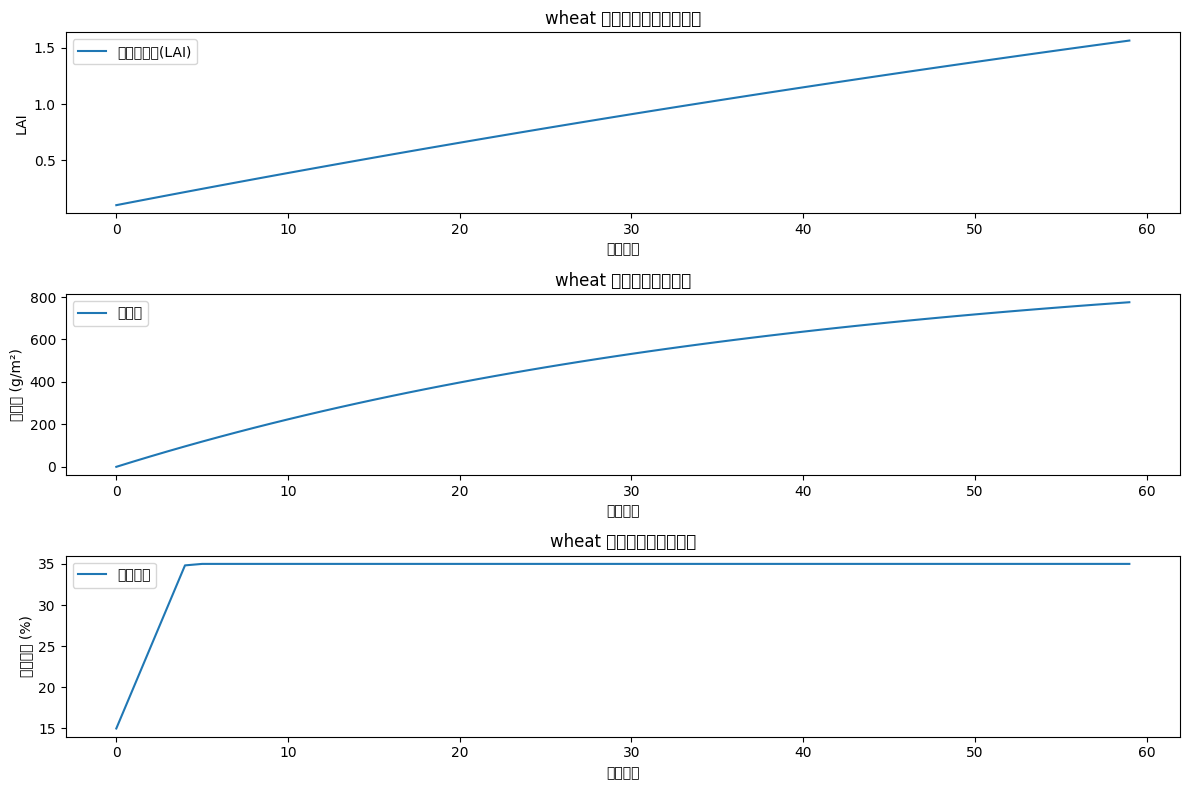

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class CropGrowthModel:
    def __init__(self, crop_type, soil_type, initial_soil_moisture, initial_lai=0.1, initial_biomass=0.01):
        """
        初始化作物生长模型。

        :param crop_type: 作物类型
        :param soil_type: 土壤类型
        :param initial_soil_moisture: 初始土壤湿度
        :param initial_lai: 初始叶面积指数
        :param initial_biomass: 初始生物量
        """
        self.crop_type = crop_type
        self.soil_type = soil_type
        self.soil_moisture = initial_soil_moisture
        self.lai = initial_lai
        self.biomass = initial_biomass
        self.days_since_planting = 0
        self.temperature = 0
        self.rainfall = 0
        self.sunlight = 0
        self.irrigation = 0
        self.cumulative_temperature = 0  # 累积有效温度
        self.growth_stage = 0  # 当前生长阶段索引

        # 根据作物类型和土壤类型设定生长参数
        self.growth_parameters = {
            'wheat': {
                'soil_moisture_optimal_range': [(10, 20), (20, 30), (25, 35), (30, 40), (35, 45), (40, 50), (45, 55), (50, 60)],
                'growth_stages': ['播种', '出苗', '分蘖', '拔节', '抽穗', '开花', '灌浆', '成熟'],
                'days_to_next_stage': [10, 15, 20, 25, 30, 35, 40, 45],
                'lai_max': 5,
                'biomass_max': 1000,
                'base_temperature': 5,  # 基础温度
                'effective_temperature_thresholds': [100, 200, 300, 400, 500, 600, 700, 800]  # 积温阈值
            },
            'corn': {
                'soil_moisture_optimal_range': [(15, 25), (25, 35), (30, 40), (35, 45), (40, 50), (45, 55), (50, 60), (55, 65)],
                'growth_stages': ['播种', '出苗', '分蘖', '拔节', '抽穗', '开花', '灌浆', '成熟'],
                'days_to_next_stage': [12, 18, 22, 27, 32, 37, 42, 47],
                'lai_max': 6,
                'biomass_max': 1200,
                'base_temperature': 10,  # 基础温度
                'effective_temperature_thresholds': [150, 250, 350, 450, 550, 650, 750, 850]  # 积温阈值
            }
        }
        self.lai_history = [self.lai]
        self.biomass_history = [self.biomass]
        self.soil_moisture_history = [self.soil_moisture]
        self.days_history = [self.days_since_planting]
        self.evapotranspiration_history = []  # 记录每日耗水量历史

    def set_driving_variables(self, temperature, rainfall, sunlight):
        """
        设置驱动变量。

        :param temperature: 温度
        :param rainfall: 降雨量
        :param sunlight: 光照强度
        """
        self.temperature = temperature
        self.rainfall = rainfall
        self.sunlight = sunlight

    def update_soil_moisture(self):
        """更新土壤湿度"""
        # 计算作物的耗水量
        evapotranspiration = self.calculate_evapotranspiration()
        self.evapotranspiration_history.append(evapotranspiration)
        new_soil_moisture = self.soil_moisture + self.rainfall + self.irrigation - evapotranspiration
        max_field_capacity = self.get_max_field_capacity()
        self.soil_moisture = min(new_soil_moisture, max_field_capacity)
        self.irrigation = 0  # 重置灌溉量

    def calculate_evapotranspiration(self):
        """计算作物的蒸腾作用（耗水量）"""
        # 参考作物蒸散量计算公式（简化示例，实际可更精细）
        reference_et = 0.01 * self.temperature * (self.sunlight / 1000)
        # 作物系数，这里简单设定随生长阶段变化（可优化）
        crop_coefficient = self.get_crop_coefficient()
        return reference_et * crop_coefficient

    def get_crop_coefficient(self):
        """获取当前生长阶段的作物系数"""
        growth_stage = self.growth_stage
        if self.crop_type == 'wheat':
            if growth_stage == 0:
                return 0.3
            elif growth_stage == 1:
                return 0.4
            elif growth_stage == 2:
                return 0.6
            elif growth_stage == 3:
                return 0.8
            elif growth_stage == 4:
                return 1.0
            elif growth_stage == 5:
                return 1.1
            elif growth_stage == 6:
                return 1.0
            elif growth_stage == 7:
                return 0.8
        elif self.crop_type == 'corn':
            if growth_stage == 0:
                return 0.4
            elif growth_stage == 1:
                return 0.5
            elif growth_stage == 2:
                return 0.7
            elif growth_stage == 3:
                return 0.9
            elif growth_stage == 4:
                return 1.1
            elif growth_stage == 5:
                return 1.2
            elif growth_stage == 6:
                return 1.1
            elif growth_stage == 7:
                return 0.9

    def update_cumulative_temperature(self):
        """更新累积有效温度"""
        base_temperature = self.growth_parameters[self.crop_type]['base_temperature']
        effective_temperature = max(0, self.temperature - base_temperature)
        self.cumulative_temperature += effective_temperature

    def update_growth_stage(self):
        """更新生长阶段"""
        thresholds = self.growth_parameters[self.crop_type]['effective_temperature_thresholds']
        if self.cumulative_temperature >= thresholds[self.growth_stage]:
            if self.growth_stage < len(thresholds) - 1:
                self.growth_stage += 1
            else:
                print(f"{self.crop_type} 已经成熟，无需再进行生长阶段更新。")

    def needs_irrigation(self):
        """判断是否需要灌溉"""
        min_moisture, max_moisture = self.growth_parameters[self.crop_type]['soil_moisture_optimal_range'][self.growth_stage]
        if self.soil_moisture < min_moisture:
            return True
        return False

    def calculate_lai_increase_rate(self):
        """计算叶面积指数的增加率"""
        lai_max = self.growth_parameters[self.crop_type]['lai_max']
        lai_increase_rate = (lai_max - self.lai) * 0.01 * self.sunlight / 1000
        return lai_increase_rate

    def calculate_biomass_increase_rate(self):
        """计算生物量的增加率"""
        biomass_max = self.growth_parameters[self.crop_type]['biomass_max']
        biomass_increase_rate = (biomass_max - self.biomass) * 0.01 * self.temperature / 10
        return biomass_increase_rate

    def update_lai_and_biomass(self):
        """更新叶面积指数和生物量"""
        lai_increase_rate = self.calculate_lai_increase_rate()
        biomass_increase_rate = self.calculate_biomass_increase_rate()

        self.lai += lai_increase_rate
        self.biomass += biomass_increase_rate
        self.lai_history.append(self.lai)
        self.biomass_history.append(self.biomass)
        self.soil_moisture_history.append(self.soil_moisture)
        self.days_history.append(self.days_since_planting)

    def simulate_day(self):
        """模拟一天的生长过程"""
        self.days_since_planting += 1
        self.update_cumulative_temperature()
        self.update_soil_moisture()
        self.update_growth_stage()
        self.update_lai_and_biomass()

        if self.needs_irrigation():
            print(f"当前处于 {self.growth_parameters[self.crop_type]['growth_stages'][self.growth_stage]} 阶段，土壤湿度低于最佳范围，需要灌溉。")
            self.irrigate()
        else:
            print(f"当前处于 {self.growth_parameters[self.crop_type]['growth_stages'][self.growth_stage]} 阶段，土壤湿度适宜，无需灌溉。")

        print(f"第 {self.days_since_planting} 天: LAI={self.lai:.2f}, 生物量={self.biomass:.2f} g/m^2, 土壤湿度={self.soil_moisture:.2f}%, 累积有效温度={self.cumulative_temperature:.2f}")

    def irrigate(self):
        """执行灌溉操作"""
        min_moisture, max_moisture = self.growth_parameters[self.crop_type]['soil_moisture_optimal_range'][self.growth_stage]
        self.irrigation = max_moisture - self.soil_moisture
        self.soil_moisture = max_moisture
        print(f"已灌溉，当前土壤湿度为 {self.soil_moisture:.2f}%。")

    def get_max_field_capacity(self):
        """获取土壤的最大田间持水量"""
        field_capacity = {
            'clay': 45,  # 黏土
            'loam': 35,  # 壤土
            'sand': 20   # 沙土
        }
        return field_capacity.get(self.soil_type, 35)  # 默认值为壤土

    def plot_growth(self):
        """绘制作物生长相关指标随时间变化曲线"""
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(self.days_history, self.lai_history, label='叶面积指数(LAI)')
        plt.xlabel('种植天数')
        plt.ylabel('LAI')
        plt.title(f'{self.crop_type} 叶面积指数随时间变化')
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(self.days_history, self.biomass_history, label='生物量')
        plt.xlabel('种植天数')
        plt.ylabel('生物量 (g/m²)')
        plt.title(f'{self.crop_type} 生物量随时间变化')
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(self.days_history, self.soil_moisture_history, label='土壤湿度')
        plt.xlabel('种植天数')
        plt.ylabel('土壤湿度 (%)')
        plt.title(f'{self.crop_type} 土壤湿度随时间变化')
        plt.legend()

        plt.tight_layout()
        plt.show()

def main():
    # 创建作物生长模型实例
    crop_model = CropGrowthModel(crop_type='wheat', soil_type='loam', initial_soil_moisture=15)

    # 模拟连续几天的生长过程
    for day in range(1, 60):
        print(f"第 {day} 天:")
        # 设置当天的驱动变量
        crop_model.set_driving_variables(temperature=25, rainfall=5, sunlight=600)
        # 模拟一天的生长过程
        crop_model.simulate_day()
        print("")
    crop_model.plot_growth()

if __name__ == "__main__":
    main()


### 主要改动点：

1.  **增加 `get_max_field_capacity` 方法**：根据土壤类型返回其最大田间持水量。
2.  **修改 `update_soil_moisture` 方法**：在更新土壤湿度时，确保新的土壤湿度不超过田间最大持水量。

通过这些改动，模型现在能够正确处理土壤湿度超过田间最大持水量的情况，从而更加真实地模拟作物生长过程中的水分管理。

### 让耗水量与叶面积指数（LAI）相关联
为了使作物每天的耗水量与叶面积指数（LAI）相关联，我们可以调整 calculate_evapotranspiration 方法，使其考虑 LAI 对蒸腾作用的影响。通常情况下，叶面积越大，植物的蒸腾作用越强，因此耗水量也会相应增加。

我们可以将 LAI 作为一个因子乘到参考蒸散量上，以反映 LAI 对耗水量的影响。以下是修改后的代码：

第 1 天:
当前处于 播种 阶段，土壤湿度适宜，无需灌溉。
第 1 天: LAI=0.13, 生物量=25.01 g/m^2, 土壤湿度=20.00%, 累积有效温度=20.00

第 2 天:
当前处于 播种 阶段，土壤湿度适宜，无需灌溉。
第 2 天: LAI=0.16, 生物量=49.38 g/m^2, 土壤湿度=25.00%, 累积有效温度=40.00

第 3 天:
当前处于 播种 阶段，土壤湿度适宜，无需灌溉。
第 3 天: LAI=0.19, 生物量=73.15 g/m^2, 土壤湿度=30.00%, 累积有效温度=60.00

第 4 天:
当前处于 播种 阶段，土壤湿度适宜，无需灌溉。
第 4 天: LAI=0.22, 生物量=96.32 g/m^2, 土壤湿度=34.99%, 累积有效温度=80.00

第 5 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 5 天: LAI=0.25, 生物量=118.91 g/m^2, 土壤湿度=35.00%, 累积有效温度=100.00

第 6 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 6 天: LAI=0.27, 生物量=140.94 g/m^2, 土壤湿度=35.00%, 累积有效温度=120.00

第 7 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 7 天: LAI=0.30, 生物量=162.42 g/m^2, 土壤湿度=35.00%, 累积有效温度=140.00

第 8 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 8 天: LAI=0.33, 生物量=183.36 g/m^2, 土壤湿度=35.00%, 累积有效温度=160.00

第 9 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 9 天: LAI=0.36, 生物量=203.77 g/m^2, 土壤湿度=35.00%, 累积有效温度=180.00

第 10 天:
当前处于 分蘖 阶段，土壤湿度适宜，无需灌溉。
第 10 天: LAI=0.39, 生物量=223.68 g/m^2, 土壤湿度=35.00%, 累积有效温度=200.00

第 11 天:
当前处于 分蘖 阶段，土壤湿度适宜，无需灌溉。
第 11 天: LAI=0.41, 生物量=243.09 g/m^2

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15856\665870501.py:227: UserWarning: Glyph 31181 (\N{CJK UNIFIED IDEOGRAPH-79CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15856\665870501.py:227: UserWarning: Glyph 26893 (\N{CJK UNIFIED IDEOGRAPH-690D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15856\665870501.py:227: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15856\665870501.py:227: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15856\665870501.py:227: UserWarning: Glyph 21494 (\N{CJK UNIFIED IDEOGRAPH-53F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_158

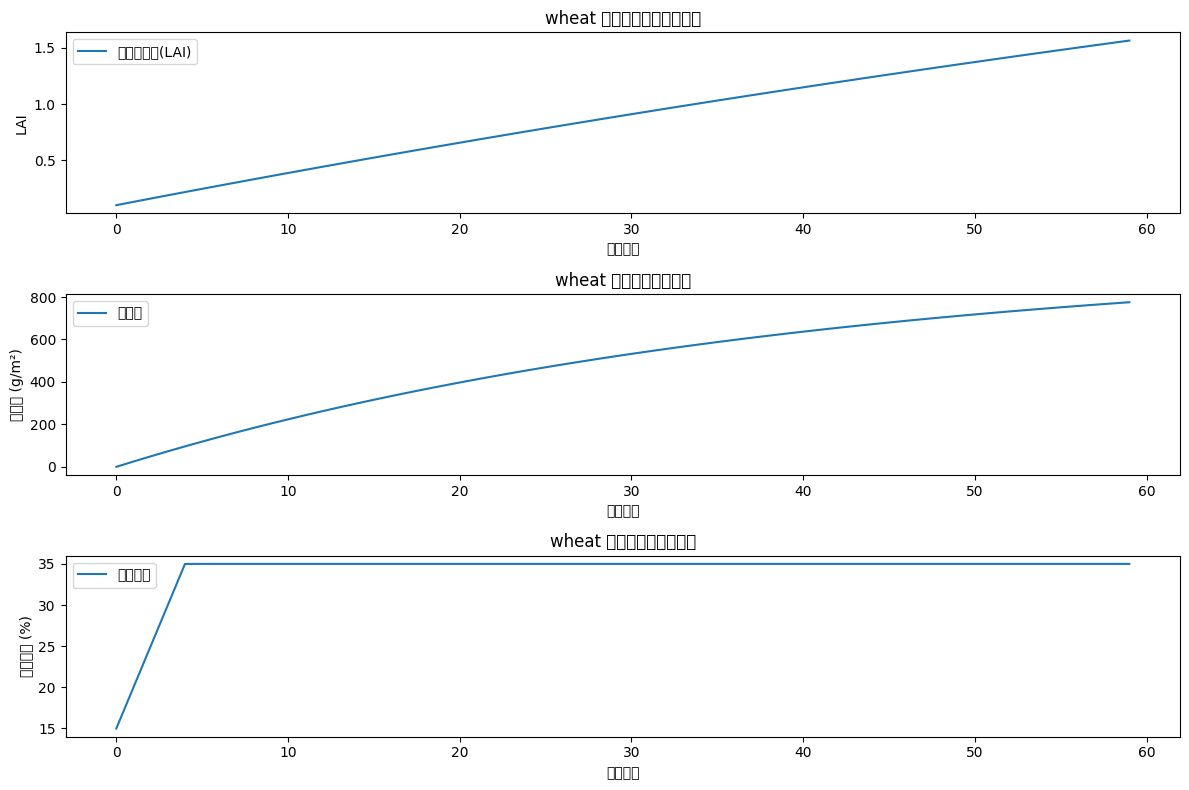

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class CropGrowthModel:
    def __init__(self, crop_type, soil_type, initial_soil_moisture, initial_lai=0.1, initial_biomass=0.01):
        """
        初始化作物生长模型。

        :param crop_type: 作物类型
        :param soil_type: 土壤类型
        :param initial_soil_moisture: 初始土壤湿度
        :param initial_lai: 初始叶面积指数
        :param initial_biomass: 初始生物量
        """
        self.crop_type = crop_type
        self.soil_type = soil_type
        self.soil_moisture = initial_soil_moisture
        self.lai = initial_lai
        self.biomass = initial_biomass
        self.days_since_planting = 0
        self.temperature = 0
        self.rainfall = 0
        self.sunlight = 0
        self.irrigation = 0
        self.cumulative_temperature = 0  # 累积有效温度
        self.growth_stage = 0  # 当前生长阶段索引

        # 根据作物类型和土壤类型设定生长参数
        self.growth_parameters = {
            'wheat': {
                'soil_moisture_optimal_range': [(10, 20), (20, 30), (25, 35), (30, 40), (35, 45), (40, 50), (45, 55), (50, 60)],
                'growth_stages': ['播种', '出苗', '分蘖', '拔节', '抽穗', '开花', '灌浆', '成熟'],
                'days_to_next_stage': [10, 15, 20, 25, 30, 35, 40, 45],
                'lai_max': 5,
                'biomass_max': 1000,
                'base_temperature': 5,  # 基础温度
                'effective_temperature_thresholds': [100, 200, 300, 400, 500, 600, 700, 800]  # 积温阈值
            },
            'corn': {
                'soil_moisture_optimal_range': [(15, 25), (25, 35), (30, 40), (35, 45), (40, 50), (45, 55), (50, 60), (55, 65)],
                'growth_stages': ['播种', '出苗', '分蘖', '拔节', '抽穗', '开花', '灌浆', '成熟'],
                'days_to_next_stage': [12, 18, 22, 27, 32, 37, 42, 47],
                'lai_max': 6,
                'biomass_max': 1200,
                'base_temperature': 10,  # 基础温度
                'effective_temperature_thresholds': [150, 250, 350, 450, 550, 650, 750, 850]  # 积温阈值
            }
        }
        self.lai_history = [self.lai]
        self.biomass_history = [self.biomass]
        self.soil_moisture_history = [self.soil_moisture]
        self.days_history = [self.days_since_planting]
        self.evapotranspiration_history = []  # 记录每日耗水量历史

    def set_driving_variables(self, temperature, rainfall, sunlight):
        """
        设置驱动变量。

        :param temperature: 温度
        :param rainfall: 降雨量
        :param sunlight: 光照强度
        """
        self.temperature = temperature
        self.rainfall = rainfall
        self.sunlight = sunlight

    def update_soil_moisture(self):
        """更新土壤湿度"""
        # 计算作物的耗水量
        evapotranspiration = self.calculate_evapotranspiration()
        self.evapotranspiration_history.append(evapotranspiration)
        new_soil_moisture = self.soil_moisture + self.rainfall + self.irrigation - evapotranspiration
        max_field_capacity = self.get_max_field_capacity()
        self.soil_moisture = min(new_soil_moisture, max_field_capacity)
        self.irrigation = 0  # 重置灌溉量

    def calculate_evapotranspiration(self):
        """计算作物的蒸腾作用（耗水量）"""
        # 参考作物蒸散量计算公式（简化示例，实际可更精细）
        reference_et = 0.01 * self.temperature * (self.sunlight / 1000)
        # 作物系数，这里简单设定随生长阶段变化（可优化）
        crop_coefficient = self.get_crop_coefficient()
        # 考虑 LAI 对蒸腾作用的影响
        lai_effect = self.lai / self.growth_parameters[self.crop_type]['lai_max']
        return reference_et * crop_coefficient * lai_effect

    def get_crop_coefficient(self):
        """获取当前生长阶段的作物系数"""
        growth_stage = self.growth_stage
        if self.crop_type == 'wheat':
            if growth_stage == 0:
                return 0.3
            elif growth_stage == 1:
                return 0.4
            elif growth_stage == 2:
                return 0.6
            elif growth_stage == 3:
                return 0.8
            elif growth_stage == 4:
                return 1.0
            elif growth_stage == 5:
                return 1.1
            elif growth_stage == 6:
                return 1.0
            elif growth_stage == 7:
                return 0.8
        elif self.crop_type == 'corn':
            if growth_stage == 0:
                return 0.4
            elif growth_stage == 1:
                return 0.5
            elif growth_stage == 2:
                return 0.7
            elif growth_stage == 3:
                return 0.9
            elif growth_stage == 4:
                return 1.1
            elif growth_stage == 5:
                return 1.2
            elif growth_stage == 6:
                return 1.1
            elif growth_stage == 7:
                return 0.9

    def update_cumulative_temperature(self):
        """更新累积有效温度"""
        base_temperature = self.growth_parameters[self.crop_type]['base_temperature']
        effective_temperature = max(0, self.temperature - base_temperature)
        self.cumulative_temperature += effective_temperature

    def update_growth_stage(self):
        """更新生长阶段"""
        thresholds = self.growth_parameters[self.crop_type]['effective_temperature_thresholds']
        if self.cumulative_temperature >= thresholds[self.growth_stage]:
            if self.growth_stage < len(thresholds) - 1:
                self.growth_stage += 1
            else:
                print(f"{self.crop_type} 已经成熟，无需再进行生长阶段更新。")

    def needs_irrigation(self):
        """判断是否需要灌溉"""
        min_moisture, max_moisture = self.growth_parameters[self.crop_type]['soil_moisture_optimal_range'][self.growth_stage]
        if self.soil_moisture < min_moisture:
            return True
        return False

    def calculate_lai_increase_rate(self):
        """计算叶面积指数的增加率"""
        lai_max = self.growth_parameters[self.crop_type]['lai_max']
        lai_increase_rate = (lai_max - self.lai) * 0.01 * self.sunlight / 1000
        return lai_increase_rate

    def calculate_biomass_increase_rate(self):
        """计算生物量的增加率"""
        biomass_max = self.growth_parameters[self.crop_type]['biomass_max']
        biomass_increase_rate = (biomass_max - self.biomass) * 0.01 * self.temperature / 10
        return biomass_increase_rate

    def update_lai_and_biomass(self):
        """更新叶面积指数和生物量"""
        lai_increase_rate = self.calculate_lai_increase_rate()
        biomass_increase_rate = self.calculate_biomass_increase_rate()

        self.lai += lai_increase_rate
        self.biomass += biomass_increase_rate
        self.lai_history.append(self.lai)
        self.biomass_history.append(self.biomass)
        self.soil_moisture_history.append(self.soil_moisture)
        self.days_history.append(self.days_since_planting)

    def simulate_day(self):
        """模拟一天的生长过程"""
        self.days_since_planting += 1
        self.update_cumulative_temperature()
        self.update_soil_moisture()
        self.update_growth_stage()
        self.update_lai_and_biomass()

        if self.needs_irrigation():
            print(f"当前处于 {self.growth_parameters[self.crop_type]['growth_stages'][self.growth_stage]} 阶段，土壤湿度低于最佳范围，需要灌溉。")
            self.irrigate()
        else:
            print(f"当前处于 {self.growth_parameters[self.crop_type]['growth_stages'][self.growth_stage]} 阶段，土壤湿度适宜，无需灌溉。")

        print(f"第 {self.days_since_planting} 天: LAI={self.lai:.2f}, 生物量={self.biomass:.2f} g/m^2, 土壤湿度={self.soil_moisture:.2f}%, 累积有效温度={self.cumulative_temperature:.2f}")

    def irrigate(self):
        """执行灌溉操作"""
        min_moisture, max_moisture = self.growth_parameters[self.crop_type]['soil_moisture_optimal_range'][self.growth_stage]
        self.irrigation = max_moisture - self.soil_moisture
        self.soil_moisture = max_moisture
        print(f"已灌溉，当前土壤湿度为 {self.soil_moisture:.2f}%。")

    def get_max_field_capacity(self):
        """获取土壤的最大田间持水量"""
        field_capacity = {
            'clay': 45,  # 黏土
            'loam': 35,  # 壤土
            'sand': 20   # 沙土
        }
        return field_capacity.get(self.soil_type, 35)  # 默认值为壤土

    def plot_growth(self):
        """绘制作物生长相关指标随时间变化曲线"""
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(self.days_history, self.lai_history, label='叶面积指数(LAI)')
        plt.xlabel('种植天数')
        plt.ylabel('LAI')
        plt.title(f'{self.crop_type} 叶面积指数随时间变化')
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(self.days_history, self.biomass_history, label='生物量')
        plt.xlabel('种植天数')
        plt.ylabel('生物量 (g/m²)')
        plt.title(f'{self.crop_type} 生物量随时间变化')
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(self.days_history, self.soil_moisture_history, label='土壤湿度')
        plt.xlabel('种植天数')
        plt.ylabel('土壤湿度 (%)')
        plt.title(f'{self.crop_type} 土壤湿度随时间变化')
        plt.legend()

        plt.tight_layout()
        plt.show()

def main():
    # 创建作物生长模型实例
    crop_model = CropGrowthModel(crop_type='wheat', soil_type='loam', initial_soil_moisture=15)

    # 模拟连续几天的生长过程
    for day in range(1, 60):
        print(f"第 {day} 天:")
        # 设置当天的驱动变量
        crop_model.set_driving_variables(temperature=25, rainfall=5, sunlight=600)
        # 模拟一天的生长过程
        crop_model.simulate_day()
        print("")
    crop_model.plot_growth()

if __name__ == "__main__":
    main()

### 主要改动点：

1.  **修改 `calculate_evapotranspiration` 方法**：增加了对 LAI 的考虑，通过 `lai_effect` 将 LAI 归一化到最大 LAI，然后乘到参考蒸散量上。
2.  **保留原有逻辑**：其他部分保持不变，确保模型的整体逻辑和功能不受影响。

通过这些改动，模型现在能够更准确地模拟作物每天的耗水量，使其与叶面积指数（LAI）相关联。这样可以更好地反映作物生长过程中水分需求的变化。

### 修改作物耗水量的计算，增加 P-M的公式代码

为了使用 Penman-Monteith (P-M) 公式计算作物的蒸腾作用（耗水量），我们需要引入一些额外的气象参数，并根据 P-M 公式的标准形式进行计算。Penman-Monteith 公式是估算参考作物蒸散量（ET₀）的标准方法，公式如下：

第 1 天:
当前处于 播种 阶段，土壤湿度适宜，无需灌溉。
第 1 天: LAI=0.13, 生物量=25.01 g/m^2, 土壤湿度=19.88%, 累积有效温度=20.00

第 2 天:
当前处于 播种 阶段，土壤湿度适宜，无需灌溉。
第 2 天: LAI=0.16, 生物量=49.38 g/m^2, 土壤湿度=24.73%, 累积有效温度=40.00

第 3 天:
当前处于 播种 阶段，土壤湿度适宜，无需灌溉。
第 3 天: LAI=0.19, 生物量=73.15 g/m^2, 土壤湿度=29.55%, 累积有效温度=60.00

第 4 天:
当前处于 播种 阶段，土壤湿度适宜，无需灌溉。
第 4 天: LAI=0.22, 生物量=96.32 g/m^2, 土壤湿度=34.33%, 累积有效温度=80.00

第 5 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 5 天: LAI=0.25, 生物量=118.91 g/m^2, 土壤湿度=35.00%, 累积有效温度=100.00

第 6 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 6 天: LAI=0.27, 生物量=140.94 g/m^2, 土壤湿度=35.00%, 累积有效温度=120.00

第 7 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 7 天: LAI=0.30, 生物量=162.42 g/m^2, 土壤湿度=35.00%, 累积有效温度=140.00

第 8 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 8 天: LAI=0.33, 生物量=183.36 g/m^2, 土壤湿度=35.00%, 累积有效温度=160.00

第 9 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 9 天: LAI=0.36, 生物量=203.77 g/m^2, 土壤湿度=35.00%, 累积有效温度=180.00

第 10 天:
当前处于 分蘖 阶段，土壤湿度适宜，无需灌溉。
第 10 天: LAI=0.39, 生物量=223.68 g/m^2, 土壤湿度=35.00%, 累积有效温度=200.00

第 11 天:
当前处于 分蘖 阶段，土壤湿度适宜，无需灌溉。
第 11 天: LAI=0.41, 生物量=243.09 g/m^2

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15856\3219252883.py:245: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()


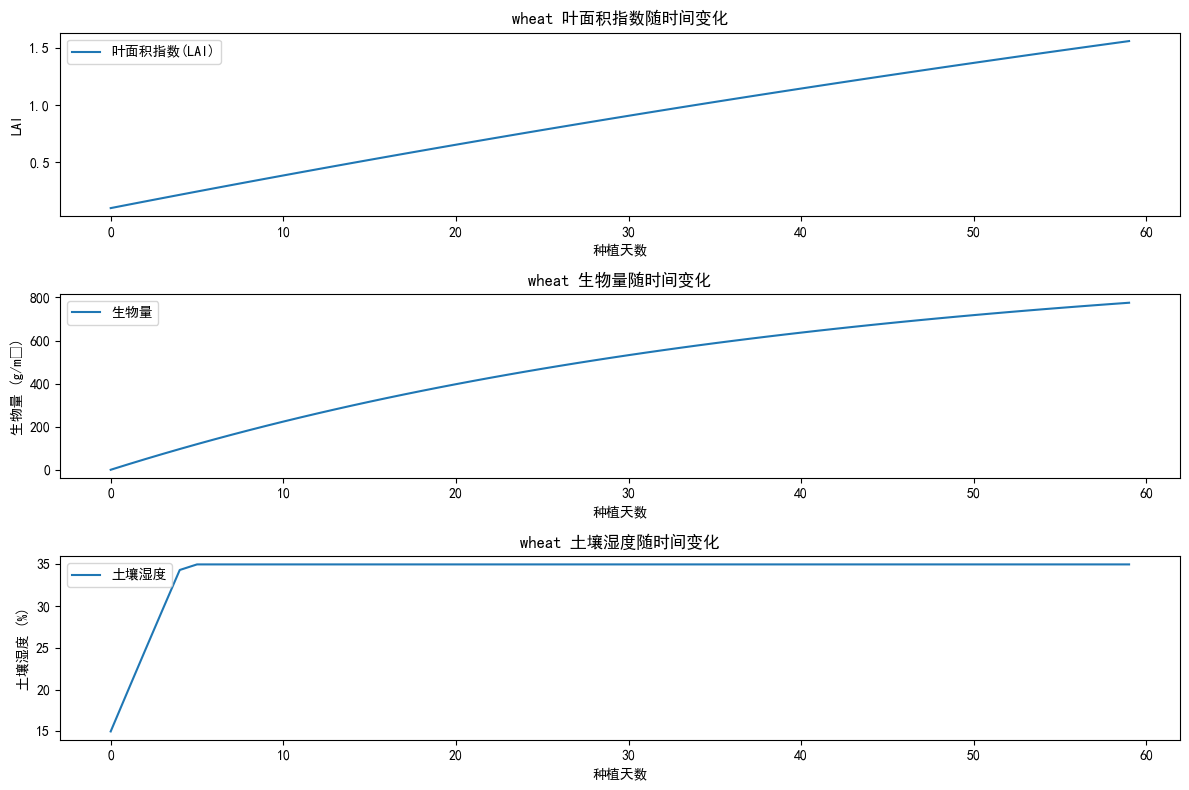

In [5]:
import numpy as np
import matplotlib.pyplot as plt

class CropGrowthModel:
    def __init__(self, crop_type, soil_type, initial_soil_moisture, initial_lai=0.1, initial_biomass=0.01):
        """
        初始化作物生长模型。

        :param crop_type: 作物类型
        :param soil_type: 土壤类型
        :param initial_soil_moisture: 初始土壤湿度
        :param initial_lai: 初始叶面积指数
        :param initial_biomass: 初始生物量
        """
        self.crop_type = crop_type
        self.soil_type = soil_type
        self.soil_moisture = initial_soil_moisture
        self.lai = initial_lai
        self.biomass = initial_biomass
        self.days_since_planting = 0
        self.temperature = 0
        self.rainfall = 0
        self.sunlight = 0
        self.wind_speed = 2  # 默认风速为2 m/s
        self.net_radiation = 15  # 默认净辐射量为15 MJ/m²/day
        self.soil_heat_flux = 0  # 默认土壤热通量为0 MJ/m²/day
        self.irrigation = 0
        self.cumulative_temperature = 0  # 累积有效温度
        self.growth_stage = 0  # 当前生长阶段索引

        # 根据作物类型和土壤类型设定生长参数
        self.growth_parameters = {
            'wheat': {
                'soil_moisture_optimal_range': [(10, 20), (20, 30), (25, 35), (30, 40), (35, 45), (40, 50), (45, 55), (50, 60)],
                'growth_stages': ['播种', '出苗', '分蘖', '拔节', '抽穗', '开花', '灌浆', '成熟'],
                'days_to_next_stage': [10, 15, 20, 25, 30, 35, 40, 45],
                'lai_max': 5,
                'biomass_max': 1000,
                'base_temperature': 5,  # 基础温度
                'effective_temperature_thresholds': [100, 200, 300, 400, 500, 600, 700, 800]  # 积温阈值
            },
            'corn': {
                'soil_moisture_optimal_range': [(15, 25), (25, 35), (30, 40), (35, 45), (40, 50), (45, 55), (50, 60), (55, 65)],
                'growth_stages': ['播种', '出苗', '分蘖', '拔节', '抽穗', '开花', '灌浆', '成熟'],
                'days_to_next_stage': [12, 18, 22, 27, 32, 37, 42, 47],
                'lai_max': 6,
                'biomass_max': 1200,
                'base_temperature': 10,  # 基础温度
                'effective_temperature_thresholds': [150, 250, 350, 450, 550, 650, 750, 850]  # 积温阈值
            }
        }
        self.lai_history = [self.lai]
        self.biomass_history = [self.biomass]
        self.soil_moisture_history = [self.soil_moisture]
        self.days_history = [self.days_since_planting]
        self.evapotranspiration_history = []  # 记录每日耗水量历史

    def set_driving_variables(self, temperature, rainfall, sunlight, wind_speed, net_radiation):
        """
        设置驱动变量。

        :param temperature: 温度 (°C)
        :param rainfall: 降雨量 (mm)
        :param sunlight: 光照强度 (W/m²)
        :param wind_speed: 风速 (m/s)
        :param net_radiation: 净辐射量 (MJ/m²/day)
        """
        self.temperature = temperature
        self.rainfall = rainfall
        self.sunlight = sunlight
        self.wind_speed = wind_speed
        self.net_radiation = net_radiation

    def update_soil_moisture(self):
        """更新土壤湿度"""
        # 计算作物的耗水量
        evapotranspiration = self.calculate_evapotranspiration()
        self.evapotranspiration_history.append(evapotranspiration)
        new_soil_moisture = self.soil_moisture + self.rainfall + self.irrigation - evapotranspiration
        max_field_capacity = self.get_max_field_capacity()
        self.soil_moisture = min(new_soil_moisture, max_field_capacity)
        self.irrigation = 0  # 重置灌溉量

    def calculate_evapotranspiration(self):
        """计算作物的蒸腾作用（耗水量）"""
        # 计算饱和水汽压和实际水汽压
        es = 0.6108 * np.exp((17.27 * self.temperature) / (self.temperature + 237.3))  # kPa
        ea = 0.6108 * np.exp((17.27 * (self.temperature - 10)) / ((self.temperature - 10) + 237.3))  # kPa

        # 计算饱和水汽压随温度的变化率
        delta = 4098 * (0.6108 * np.exp((17.27 * self.temperature) / (self.temperature + 237.3))) / (self.temperature + 237.3)**2  # kPa/°C

        # 心理常数
        gamma = 0.067  # kPa/°C

        # Penman-Monteith 公式
        et0 = (0.408 * delta * (self.net_radiation - self.soil_heat_flux) +
               gamma * (900 / (self.temperature + 273)) * self.wind_speed * (es - ea)) / \
              (delta + gamma * (1 + 0.34 * self.wind_speed))

        # 考虑 LAI 对蒸腾作用的影响
        lai_effect = self.lai / self.growth_parameters[self.crop_type]['lai_max']
        return et0 * lai_effect

    def get_crop_coefficient(self):
        """获取当前生长阶段的作物系数"""
        growth_stage = self.growth_stage
        if self.crop_type == 'wheat':
            if growth_stage == 0:
                return 0.3
            elif growth_stage == 1:
                return 0.4
            elif growth_stage == 2:
                return 0.6
            elif growth_stage == 3:
                return 0.8
            elif growth_stage == 4:
                return 1.0
            elif growth_stage == 5:
                return 1.1
            elif growth_stage == 6:
                return 1.0
            elif growth_stage == 7:
                return 0.8
        elif self.crop_type == 'corn':
            if growth_stage == 0:
                return 0.4
            elif growth_stage == 1:
                return 0.5
            elif growth_stage == 2:
                return 0.7
            elif growth_stage == 3:
                return 0.9
            elif growth_stage == 4:
                return 1.1
            elif growth_stage == 5:
                return 1.2
            elif growth_stage == 6:
                return 1.1
            elif growth_stage == 7:
                return 0.9

    def update_cumulative_temperature(self):
        """更新累积有效温度"""
        base_temperature = self.growth_parameters[self.crop_type]['base_temperature']
        effective_temperature = max(0, self.temperature - base_temperature)
        self.cumulative_temperature += effective_temperature

    def update_growth_stage(self):
        """更新生长阶段"""
        thresholds = self.growth_parameters[self.crop_type]['effective_temperature_thresholds']
        if self.cumulative_temperature >= thresholds[self.growth_stage]:
            if self.growth_stage < len(thresholds) - 1:
                self.growth_stage += 1
            else:
                print(f"{self.crop_type} 已经成熟，无需再进行生长阶段更新。")

    def needs_irrigation(self):
        """判断是否需要灌溉"""
        min_moisture, max_moisture = self.growth_parameters[self.crop_type]['soil_moisture_optimal_range'][self.growth_stage]
        if self.soil_moisture < min_moisture:
            return True
        return False

    def calculate_lai_increase_rate(self):
        """计算叶面积指数的增加率"""
        lai_max = self.growth_parameters[self.crop_type]['lai_max']
        lai_increase_rate = (lai_max - self.lai) * 0.01 * self.sunlight / 1000
        return lai_increase_rate

    def calculate_biomass_increase_rate(self):
        """计算生物量的增加率"""
        biomass_max = self.growth_parameters[self.crop_type]['biomass_max']
        biomass_increase_rate = (biomass_max - self.biomass) * 0.01 * self.temperature / 10
        return biomass_increase_rate

    def update_lai_and_biomass(self):
        """更新叶面积指数和生物量"""
        lai_increase_rate = self.calculate_lai_increase_rate()
        biomass_increase_rate = self.calculate_biomass_increase_rate()

        self.lai += lai_increase_rate
        self.biomass += biomass_increase_rate
        self.lai_history.append(self.lai)
        self.biomass_history.append(self.biomass)
        self.soil_moisture_history.append(self.soil_moisture)
        self.days_history.append(self.days_since_planting)

    def simulate_day(self):
        """模拟一天的生长过程"""
        self.days_since_planting += 1
        self.update_cumulative_temperature()
        self.update_soil_moisture()
        self.update_growth_stage()
        self.update_lai_and_biomass()

        if self.needs_irrigation():
            print(f"当前处于 {self.growth_parameters[self.crop_type]['growth_stages'][self.growth_stage]} 阶段，土壤湿度低于最佳范围，需要灌溉。")
            self.irrigate()
        else:
            print(f"当前处于 {self.growth_parameters[self.crop_type]['growth_stages'][self.growth_stage]} 阶段，土壤湿度适宜，无需灌溉。")

        print(f"第 {self.days_since_planting} 天: LAI={self.lai:.2f}, 生物量={self.biomass:.2f} g/m^2, 土壤湿度={self.soil_moisture:.2f}%, 累积有效温度={self.cumulative_temperature:.2f}")

    def irrigate(self):
        """执行灌溉操作"""
        min_moisture, max_moisture = self.growth_parameters[self.crop_type]['soil_moisture_optimal_range'][self.growth_stage]
        self.irrigation = max_moisture - self.soil_moisture
        self.soil_moisture = max_moisture
        print(f"已灌溉，当前土壤湿度为 {self.soil_moisture:.2f}%。")

    def get_max_field_capacity(self):
        """获取土壤的最大田间持水量"""
        field_capacity = {
            'clay': 45,  # 黏土
            'loam': 35,  # 壤土
            'sand': 20   # 沙土
        }
        return field_capacity.get(self.soil_type, 35)  # 默认值为壤土

    def plot_growth(self):
        """绘制作物生长相关指标随时间变化曲线"""
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(self.days_history, self.lai_history, label='叶面积指数(LAI)')
        plt.xlabel('种植天数')
        plt.ylabel('LAI')
        plt.title(f'{self.crop_type} 叶面积指数随时间变化')
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(self.days_history, self.biomass_history, label='生物量')
        plt.xlabel('种植天数')
        plt.ylabel('生物量 (g/m²)')
        plt.title(f'{self.crop_type} 生物量随时间变化')
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(self.days_history, self.soil_moisture_history, label='土壤湿度')
        plt.xlabel('种植天数')
        plt.ylabel('土壤湿度 (%)')
        plt.title(f'{self.crop_type} 土壤湿度随时间变化')
        plt.legend()

        plt.tight_layout()
        plt.show()

def main():
    # 创建作物生长模型实例
    crop_model = CropGrowthModel(crop_type='wheat', soil_type='loam', initial_soil_moisture=15)

    # 模拟连续几天的生长过程
    for day in range(1, 60):
        print(f"第 {day} 天:")
        # 设置当天的驱动变量
        crop_model.set_driving_variables(temperature=25, rainfall=5, sunlight=600, wind_speed=2, net_radiation=15)
        # 模拟一天的生长过程
        crop_model.simulate_day()
        print("")
    crop_model.plot_growth()

if __name__ == "__main__":
    main()

### 主要改动点：

1.  **引入新的气象参数**：在 `set_driving_variables` 方法中增加了 `wind_speed` 和 `net_radiation` 参数。
2.  **修改 `calculate_evapotranspiration` 方法**：使用 Penman-Monteith 公式计算参考作物蒸散量（ET₀），并考虑 LAI 对蒸腾作用的影响。
3.  **保留原有逻辑**：其他部分保持不变，确保模型的整体逻辑和功能不受影响。

通过这些改动，模型现在能够更准确地模拟作物每天的耗水量，使用了更精确的 Penman-Monteith 公式来计算参考作物蒸散量。这样可以更好地反映作物生长过程中水分需求的变化。

### 叶面积指数（LAI）和作物系数（crop coefficient, Kc）对蒸腾作用

为了更准确地考虑叶面积指数（LAI）和作物系数（crop coefficient, Kc）对蒸腾作用的影响，我们可以在 calculate_evapotranspiration 方法中同时应用这两个因素。具体来说，我们先计算参考作物蒸散量（ET₀），然后乘以作物系数（Kc）和 LAI 效应（lai_effect）。

以下是修正后的代码：

第 1 天:
当前处于 播种 阶段，土壤湿度适宜，无需灌溉。
第 1 天: LAI=0.13, 生物量=25.01 g/m^2, 土壤湿度=18.67%, 累积有效温度=20.00

第 2 天:
当前处于 播种 阶段，土壤湿度适宜，无需灌溉。
第 2 天: LAI=0.16, 生物量=49.38 g/m^2, 土壤湿度=22.32%, 累积有效温度=40.00

第 3 天:
当前处于 播种 阶段，土壤湿度适宜，无需灌溉。
第 3 天: LAI=0.19, 生物量=73.15 g/m^2, 土壤湿度=25.94%, 累积有效温度=60.00

第 4 天:
当前处于 播种 阶段，土壤湿度适宜，无需灌溉。
第 4 天: LAI=0.22, 生物量=96.32 g/m^2, 土壤湿度=29.55%, 累积有效温度=80.00

第 5 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 5 天: LAI=0.25, 生物量=118.91 g/m^2, 土壤湿度=33.14%, 累积有效温度=100.00

第 6 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 6 天: LAI=0.27, 生物量=140.94 g/m^2, 土壤湿度=35.00%, 累积有效温度=120.00

第 7 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 7 天: LAI=0.30, 生物量=162.42 g/m^2, 土壤湿度=35.00%, 累积有效温度=140.00

第 8 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 8 天: LAI=0.33, 生物量=183.36 g/m^2, 土壤湿度=35.00%, 累积有效温度=160.00

第 9 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 9 天: LAI=0.36, 生物量=203.77 g/m^2, 土壤湿度=35.00%, 累积有效温度=180.00

第 10 天:
当前处于 分蘖 阶段，土壤湿度适宜，无需灌溉。
第 10 天: LAI=0.39, 生物量=223.68 g/m^2, 土壤湿度=35.00%, 累积有效温度=200.00

第 11 天:
当前处于 分蘖 阶段，土壤湿度适宜，无需灌溉。
第 11 天: LAI=0.41, 生物量=243.09 g/m^2

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15856\3487115746.py:265: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()
C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


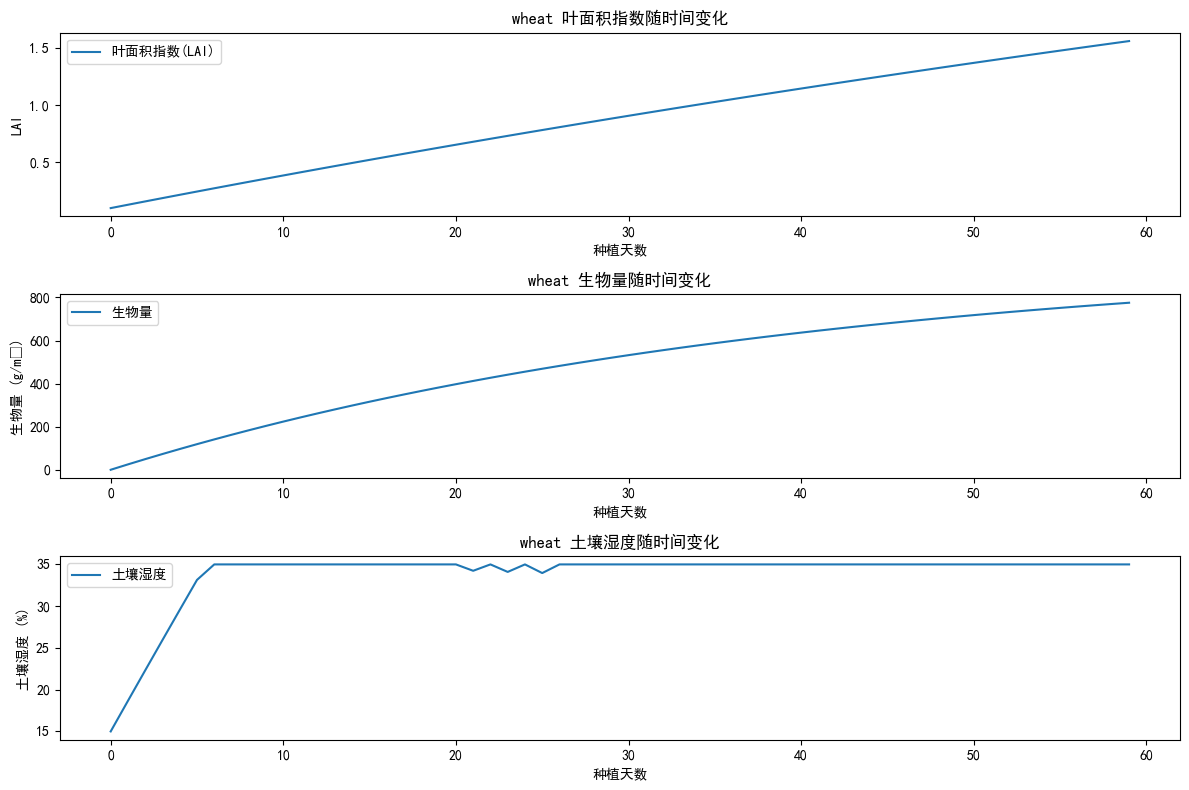

In [10]:
import numpy as np
import math
import matplotlib.pyplot as plt
# 设置中文字体为黑体，可根据实际情况替换为其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False

class CropGrowthModel:
    def __init__(self, crop_type, soil_type, initial_soil_moisture, initial_lai=0.1, initial_biomass=0.01):
        """
        初始化作物生长模型。

        :param crop_type: 作物类型
        :param soil_type: 土壤类型
        :param initial_soil_moisture: 初始土壤湿度
        :param initial_lai: 初始叶面积指数
        :param initial_biomass: 初始生物量
        """
        self.crop_type = crop_type
        self.soil_type = soil_type
        self.soil_moisture = initial_soil_moisture
        self.lai = initial_lai
        self.biomass = initial_biomass
        self.days_since_planting = 0
        self.temperature = 0
        self.rainfall = 0
        self.sunlight = 0
        self.wind_speed = 2  # 默认风速为2 m/s
        self.net_radiation = 15  # 默认净辐射量为15 MJ/m²/day
        self.soil_heat_flux = 0  # 默认土壤热通量为0 MJ/m²/day
        self.irrigation = 0
        self.cumulative_temperature = 0  # 累积有效温度
        self.growth_stage = 0  # 当前生长阶段索引

        # 根据作物类型和土壤类型设定生长参数
        self.growth_parameters = {
            'wheat': {
                'soil_moisture_optimal_range': [(10, 20), (20, 30), (25, 35), (30, 40), (35, 45), (40, 50), (45, 55), (50, 60)],
                'growth_stages': ['播种', '出苗', '分蘖', '拔节', '抽穗', '开花', '灌浆', '成熟'],
                'days_to_next_stage': [10, 15, 20, 25, 30, 35, 40, 45],
                'lai_max': 5,
                'biomass_max': 1000,
                'base_temperature': 5,  # 基础温度
                'effective_temperature_thresholds': [100, 200, 300, 400, 500, 600, 700, 800]  # 积温阈值
            },
            'corn': {
                'soil_moisture_optimal_range': [(15, 25), (25, 35), (30, 40), (35, 45), (40, 50), (45, 55), (50, 60), (55, 65)],
                'growth_stages': ['播种', '出苗', '分蘖', '拔节', '抽穗', '开花', '灌浆', '成熟'],
                'days_to_next_stage': [12, 18, 22, 27, 32, 37, 42, 47],
                'lai_max': 6,
                'biomass_max': 1200,
                'base_temperature': 10,  # 基础温度
                'effective_temperature_thresholds': [150, 250, 350, 450, 550, 650, 750, 850]  # 积温阈值
            }
        }
        self.lai_history = [self.lai]
        self.biomass_history = [self.biomass]
        self.soil_moisture_history = [self.soil_moisture]
        self.days_history = [self.days_since_planting]
        self.evapotranspiration_history = []  # 记录每日耗水量历史

    def set_driving_variables(self, temperature, rainfall, sunlight, wind_speed, net_radiation):
        """
        设置驱动变量。

        :param temperature: 温度 (°C)
        :param rainfall: 降雨量 (mm)
        :param sunlight: 光照强度 (W/m²)
        :param wind_speed: 风速 (m/s)
        :param net_radiation: 净辐射量 (MJ/m²/day)
        """
        self.temperature = temperature
        self.rainfall = rainfall
        self.sunlight = sunlight
        self.wind_speed = wind_speed
        self.net_radiation = net_radiation

    def update_soil_moisture(self):
        """更新土壤湿度"""
        # 计算作物的耗水量
        evapotranspiration = self.calculate_evapotranspiration()
        self.evapotranspiration_history.append(evapotranspiration)
        new_soil_moisture = self.soil_moisture + self.rainfall + self.irrigation - evapotranspiration
        max_field_capacity = self.get_max_field_capacity()
        self.soil_moisture = min(new_soil_moisture, max_field_capacity)
        self.irrigation = 0  # 重置灌溉量

    def calculate_evapotranspiration(self):
        """计算作物的蒸腾作用（耗水量）"""
        # 计算饱和水汽压和实际水汽压
        es = 0.6108 * np.exp((17.27 * self.temperature) / (self.temperature + 237.3))  # kPa
        ea = 0.6108 * np.exp((17.27 * (self.temperature - 10)) / ((self.temperature - 10) + 237.3))  # kPa

        # 计算饱和水汽压随温度的变化率
        delta = 4098 * (0.6108 * np.exp((17.27 * self.temperature) / (self.temperature + 237.3))) / (self.temperature + 237.3)**2  # kPa/°C

        # 心理常数
        gamma = 0.067  # kPa/°C

        # Penman-Monteith 公式
        et0 = (0.408 * delta * (self.net_radiation - self.soil_heat_flux) +
               gamma * (900 / (self.temperature + 273)) * self.wind_speed * (es - ea)) / \
              (delta + gamma * (1 + 0.34 * self.wind_speed))

        # 获取当前生长阶段的作物系数
        kc = self.get_crop_coefficient()

        # 考虑 LAI 对蒸腾作用的影响
        # lai_effect = self.lai / self.growth_parameters[self.crop_type]['lai_max']
        # sigmoid function parameters
        
        # 在作物生长模型中，叶面积指数（Leaf Area Index, LAI）对作物的耗水量有着直接的影响。
        # 一个更加细致和合理的公式可以考虑LAI与最大LAI的关系，同时引入一个非线性关系，
        # 来模拟LAI较低或较高时对作物耗水量的不同影响。
        # 我们可以使用一个sigmoid函数或者类似的形式来实现这一点。
        
        k = 0.3  # Steepness of the curve
        x0 = self.growth_parameters[self.crop_type]['lai_max'] / 2  # Inflection point
        lai_effect = (1 + math.tanh(k * (self.lai - x0))) / 2
        # lai_effect=1
        # 综合考虑作物系数和 LAI 效应
        return et0 * kc * (4*lai_effect)

    def get_crop_coefficient(self):
        """获取当前生长阶段的作物系数"""
        growth_stage = self.growth_stage
        if self.crop_type == 'wheat':
            if growth_stage == 0:
                return 0.3
            elif growth_stage == 1:
                return 0.4
            elif growth_stage == 2:
                return 0.6
            elif growth_stage == 3:
                return 0.8
            elif growth_stage == 4:
                return 1.0
            elif growth_stage == 5:
                return 1.1
            elif growth_stage == 6:
                return 1.0
            elif growth_stage == 7:
                return 0.8
        elif self.crop_type == 'corn':
            if growth_stage == 0:
                return 0.4
            elif growth_stage == 1:
                return 0.5
            elif growth_stage == 2:
                return 0.7
            elif growth_stage == 3:
                return 0.9
            elif growth_stage == 4:
                return 1.1
            elif growth_stage == 5:
                return 1.2
            elif growth_stage == 6:
                return 1.1
            elif growth_stage == 7:
                return 0.9

    def update_cumulative_temperature(self):
        """更新累积有效温度"""
        base_temperature = self.growth_parameters[self.crop_type]['base_temperature']
        effective_temperature = max(0, self.temperature - base_temperature)
        self.cumulative_temperature += effective_temperature

    def update_growth_stage(self):
        """更新生长阶段"""
        thresholds = self.growth_parameters[self.crop_type]['effective_temperature_thresholds']
        if self.cumulative_temperature >= thresholds[self.growth_stage]:
            if self.growth_stage < len(thresholds) - 1:
                self.growth_stage += 1
            else:
                print(f"{self.crop_type} 已经成熟，无需再进行生长阶段更新。")

    def needs_irrigation(self):
        """判断是否需要灌溉"""
        min_moisture, max_moisture = self.growth_parameters[self.crop_type]['soil_moisture_optimal_range'][self.growth_stage]
        if self.soil_moisture < min_moisture:
            return True
        return False

    def calculate_lai_increase_rate(self):
        """计算叶面积指数的增加率"""
        lai_max = self.growth_parameters[self.crop_type]['lai_max']
        lai_increase_rate = (lai_max - self.lai) * 0.01 * self.sunlight / 1000
        return lai_increase_rate

    def calculate_biomass_increase_rate(self):
        """计算生物量的增加率"""
        biomass_max = self.growth_parameters[self.crop_type]['biomass_max']
        biomass_increase_rate = (biomass_max - self.biomass) * 0.01 * self.temperature / 10
        return biomass_increase_rate

    def update_lai_and_biomass(self):
        """更新叶面积指数和生物量"""
        lai_increase_rate = self.calculate_lai_increase_rate()
        biomass_increase_rate = self.calculate_biomass_increase_rate()

        self.lai += lai_increase_rate
        self.biomass += biomass_increase_rate
        self.lai_history.append(self.lai)
        self.biomass_history.append(self.biomass)
        self.soil_moisture_history.append(self.soil_moisture)
        self.days_history.append(self.days_since_planting)

    def simulate_day(self):
        """模拟一天的生长过程"""
        self.days_since_planting += 1
        self.update_cumulative_temperature()
        self.update_soil_moisture()
        self.update_growth_stage()
        self.update_lai_and_biomass()

        if self.needs_irrigation():
            print(f"当前处于 {self.growth_parameters[self.crop_type]['growth_stages'][self.growth_stage]} 阶段，土壤湿度低于最佳范围，需要灌溉。")
            self.irrigate()
        else:
            print(f"当前处于 {self.growth_parameters[self.crop_type]['growth_stages'][self.growth_stage]} 阶段，土壤湿度适宜，无需灌溉。")

        print(f"第 {self.days_since_planting} 天: LAI={self.lai:.2f}, 生物量={self.biomass:.2f} g/m^2, 土壤湿度={self.soil_moisture:.2f}%, 累积有效温度={self.cumulative_temperature:.2f}")

    def irrigate(self):
        """执行灌溉操作"""
        min_moisture, max_moisture = self.growth_parameters[self.crop_type]['soil_moisture_optimal_range'][self.growth_stage]
        self.irrigation = max_moisture - self.soil_moisture
        self.soil_moisture = max_moisture
        print(f"已灌溉，当前土壤湿度为 {self.soil_moisture:.2f}%。")

    def get_max_field_capacity(self):
        """获取土壤的最大田间持水量"""
        field_capacity = {
            'clay': 45,  # 黏土
            'loam': 35,  # 壤土
            'sand': 20   # 沙土
        }
        return field_capacity.get(self.soil_type, 35)  # 默认值为壤土

    def plot_growth(self):
        """绘制作物生长相关指标随时间变化曲线"""
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(self.days_history, self.lai_history, label='叶面积指数(LAI)')
        plt.xlabel('种植天数')
        plt.ylabel('LAI')
        plt.title(f'{self.crop_type} 叶面积指数随时间变化')
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(self.days_history, self.biomass_history, label='生物量')
        plt.xlabel('种植天数')
        plt.ylabel('生物量 (g/m²)')
        plt.title(f'{self.crop_type} 生物量随时间变化')
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(self.days_history, self.soil_moisture_history, label='土壤湿度')
        plt.xlabel('种植天数')
        plt.ylabel('土壤湿度 (%)')
        plt.title(f'{self.crop_type} 土壤湿度随时间变化')
        plt.legend()

        plt.tight_layout()
        plt.show()

def main():
    # 创建作物生长模型实例
    crop_model = CropGrowthModel(crop_type='wheat', soil_type='loam', initial_soil_moisture=15)

    # 模拟连续几天的生长过程
    for day in range(1, 60):
        print(f"第 {day} 天:")
        # 设置当天的驱动变量
        crop_model.set_driving_variables(temperature=25, rainfall=5, sunlight=600, wind_speed=2, net_radiation=15)
        # 模拟一天的生长过程
        crop_model.simulate_day()
        print("")
    crop_model.plot_growth()

if __name__ == "__main__":
    main()

### 主要改动点：

1. **修正 `calculate_evapotranspiration` 方法** ：
   * 使用 Penman-Monteith 公式计算参考作物蒸散量（ET₀）。
   * 获取当前生长阶段的作物系数（Kc）。
   * 计算 LAI 效应（lai_effect）。
   * 综合考虑作物系数和 LAI 效应，计算最终的蒸腾作用（ET）。

**解释**：  
在这个模型中，`water_consumption`方法使用了一个sigmoid函数来调整作物的耗水量。这个函数的形状确保了当LAI接近于0和`lai_max`时，增长速率会变缓。参数`k`控制曲线的陡峭程度，而`x0`设置曲线的拐点位置，通常设置为最大LAI值的一半。

通过这种方式，你可以更精细地控制LAI对作物耗水量的影响，特别是在LAI值高或低的情况下，这比简单的线性比例更有生理学意义。

2. **保留原有逻辑** ：其他部分保持不变，确保模型的整体逻辑和功能不受影响。

通过这些改动，模型现在能够更准确地模拟作物每天的耗水量，同时考虑了叶面积指数（LAI）和作物系数（Kc）对蒸腾作用的影响。这样可以更好地反映作物生长过程中水分需求的变化。


### 增加以下功能

修改 irrigate 方法中的灌溉逻辑。具体来说，我们将根据土壤类型确定最大田间持水量（field capacity），并设置最小和最大土壤湿度的限制，分别为最大田间持水量的60%和80%。如果当前土壤湿度低于最小限制，则进行灌溉，灌溉量为最大限制与当前土壤湿度之差。



在 set_driving_variables 方法中增加每天的变化量，并随机生成数据。
在绘制土壤含水量图像时，添加最高和最低含水量的两条线。

第 1 天:
当前处于 播种 阶段，土壤湿度低于最佳范围，需要灌溉。
已灌溉，当前土壤湿度为 24.50%。
第 1 天: LAI=0.13, 生物量=26.47 g/m^2, 土壤湿度=24.50%, 累积有效温度=21.46

第 2 天:
当前处于 播种 阶段，土壤湿度适宜，无需灌溉。
第 2 天: LAI=0.17, 生物量=49.65 g/m^2, 土壤湿度=33.95%, 累积有效温度=40.27

第 3 天:
当前处于 播种 阶段，土壤湿度适宜，无需灌溉。
第 3 天: LAI=0.21, 生物量=74.52 g/m^2, 土壤湿度=33.86%, 累积有效温度=61.44

第 4 天:
当前处于 播种 阶段，土壤湿度适宜，无需灌溉。
第 4 天: LAI=0.23, 生物量=98.75 g/m^2, 土壤湿度=33.86%, 累积有效温度=82.62

第 5 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 5 天: LAI=0.27, 生物量=121.42 g/m^2, 土壤湿度=33.77%, 累积有效温度=102.77

第 6 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 6 天: LAI=0.28, 生物量=140.96 g/m^2, 土壤湿度=33.29%, 累积有效温度=120.01

第 7 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 7 天: LAI=0.29, 生物量=164.39 g/m^2, 土壤湿度=33.51%, 累积有效温度=142.29

第 8 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 8 天: LAI=0.29, 生物量=185.27 g/m^2, 土壤湿度=33.16%, 累积有效温度=162.28

第 9 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 9 天: LAI=0.31, 生物量=205.52 g/m^2, 土壤湿度=33.00%, 累积有效温度=182.14

第 10 天:
当前处于 出苗 阶段，土壤湿度适宜，无需灌溉。
第 10 天: LAI=0.34, 生物量=222.31 g/m^2, 土壤湿度=32.90%, 累积有效温度=198.26

第 11 天:
当前处于 分蘖 阶段，土壤湿度适宜，无需灌溉。
第 11 天: LA

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10612\3669008351.py:267: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()


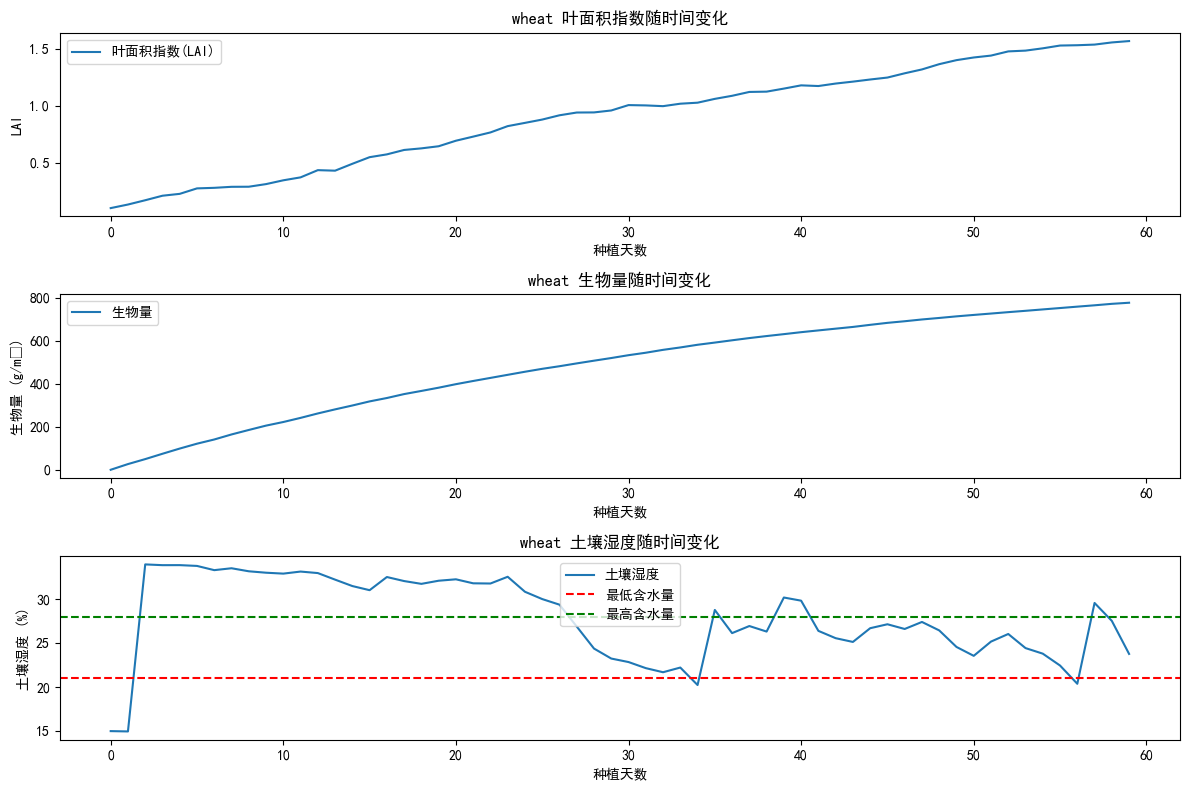

In [10]:
import numpy as np
import matplotlib.pyplot as plt
# 设置中文字体为黑体，可根据实际情况替换为其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False
class CropGrowthModel:
    def __init__(self, crop_type, soil_type, initial_soil_moisture, initial_lai=0.1, initial_biomass=0.01):
        """
        初始化作物生长模型。

        :param crop_type: 作物类型
        :param soil_type: 土壤类型
        :param initial_soil_moisture: 初始土壤湿度
        :param initial_lai: 初始叶面积指数
        :param initial_biomass: 初始生物量
        """
        self.crop_type = crop_type
        self.soil_type = soil_type
        self.soil_moisture = initial_soil_moisture
        self.lai = initial_lai
        self.biomass = initial_biomass
        self.days_since_planting = 0
        self.temperature = 0
        self.rainfall = 0
        self.sunlight = 0
        self.wind_speed = 0  # 风速
        self.net_radiation = 0  # 净辐射量
        self.soil_heat_flux = 0  # 土壤热通量
        self.irrigation = 0
        self.cumulative_temperature = 0  # 累积有效温度
        self.growth_stage = 0  # 当前生长阶段索引

        # 根据作物类型和土壤类型设定生长参数
        self.growth_parameters = {
            'wheat': {
                'soil_moisture_optimal_range': [(10, 20), (20, 30), (25, 35), (30, 40), (35, 45), (40, 50), (45, 55), (50, 60)],
                'growth_stages': ['播种', '出苗', '分蘖', '拔节', '抽穗', '开花', '灌浆', '成熟'],
                'days_to_next_stage': [10, 15, 20, 25, 30, 35, 40, 45],
                'lai_max': 5,
                'biomass_max': 1000,
                'base_temperature': 5,  # 基础温度
                'effective_temperature_thresholds': [100, 200, 300, 400, 500, 600, 700, 800]  # 积温阈值
            },
            'corn': {
                'soil_moisture_optimal_range': [(15, 25), (25, 35), (30, 40), (35, 45), (40, 50), (45, 55), (50, 60), (55, 65)],
                'growth_stages': ['播种', '出苗', '分蘖', '拔节', '抽穗', '开花', '灌浆', '成熟'],
                'days_to_next_stage': [12, 18, 22, 27, 32, 37, 42, 47],
                'lai_max': 6,
                'biomass_max': 1200,
                'base_temperature': 10,  # 基础温度
                'effective_temperature_thresholds': [150, 250, 350, 450, 550, 650, 750, 850]  # 积温阈值
            }
        }
        self.lai_history = [self.lai]
        self.biomass_history = [self.biomass]
        self.soil_moisture_history = [self.soil_moisture]
        self.days_history = [self.days_since_planting]
        self.evapotranspiration_history = []  # 记录每日耗水量历史

    def set_driving_variables(self, temperature, rainfall, sunlight):
        """
        设置驱动变量，并随机生成每天的变化量。

        :param temperature: 温度 (°C)
        :param rainfall: 降雨量 (mm)
        :param sunlight: 光照强度 (W/m²)
        """
        self.temperature = temperature + np.random.normal(0, 2)  # 温度随机变化
        # self.rainfall = rainfall + np.random.normal(0, 1)  # 降雨量随机变化
        self.rainfall = 0 # 降雨量=0 极端条件
        # self.rainfall =  np.random.normal(0, 1) *np.random.normal(0, 1) *np.random.normal(0, 1)*rainfall
        
        self.sunlight = sunlight+10 * np.random.normal(0, 50)  # 光照强度随机变化
        self.wind_speed = 2 * np.random.normal(0, 1.5)  # 风速随机变化
        self.net_radiation = 15 +10* np.random.normal(0, 2)  # 净辐射量随机变化
        self.soil_heat_flux = 1+np.random.normal(0, 1)  # 土壤热通量随机变化

    def update_soil_moisture(self):
        """更新土壤湿度"""
        # 计算作物的耗水量
        evapotranspiration = self.calculate_evapotranspiration()
        self.evapotranspiration_history.append(evapotranspiration)
        new_soil_moisture = self.soil_moisture + self.rainfall + self.irrigation - evapotranspiration
        max_field_capacity = self.get_max_field_capacity()
        self.soil_moisture = min(new_soil_moisture, max_field_capacity)
        self.irrigation = 0  # 重置灌溉量

    def calculate_evapotranspiration(self):
        """计算作物的蒸腾作用（耗水量）"""
        # 计算饱和水汽压和实际水汽压
        es = 0.6108 * np.exp((17.27 * self.temperature) / (self.temperature + 237.3))  # kPa
        ea = 0.6108 * np.exp((17.27 * (self.temperature - 10)) / ((self.temperature - 10) + 237.3))  # kPa

        # 计算饱和水汽压随温度的变化率
        delta = 4098 * (0.6108 * np.exp((17.27 * self.temperature) / (self.temperature + 237.3))) / (self.temperature + 237.3)**2  # kPa/°C

        # 心理常数
        gamma = 0.067  # kPa/°C

        # Penman-Monteith 公式
        et0 = (0.408 * delta * (self.net_radiation - self.soil_heat_flux) +
               gamma * (900 / (self.temperature + 273)) * self.wind_speed * (es - ea)) / \
              (delta + gamma * (1 + 0.34 * self.wind_speed))

        # 获取当前生长阶段的作物系数
        kc = self.get_crop_coefficient()

        # 考虑 LAI 对蒸腾作用的影响
        lai_effect = self.lai / self.growth_parameters[self.crop_type]['lai_max']

        # 综合考虑作物系数和 LAI 效应
        return et0 * kc * lai_effect

    def get_crop_coefficient(self):
        """获取当前生长阶段的作物系数"""
        growth_stage = self.growth_stage
        if self.crop_type == 'wheat':
            if growth_stage == 0:
                return 0.3
            elif growth_stage == 1:
                return 0.4
            elif growth_stage == 2:
                return 0.6
            elif growth_stage == 3:
                return 0.8
            elif growth_stage == 4:
                return 1.0
            elif growth_stage == 5:
                return 1.1
            elif growth_stage == 6:
                return 1.0
            elif growth_stage == 7:
                return 0.8
        elif self.crop_type == 'corn':
            if growth_stage == 0:
                return 0.4
            elif growth_stage == 1:
                return 0.5
            elif growth_stage == 2:
                return 0.7
            elif growth_stage == 3:
                return 0.9
            elif growth_stage == 4:
                return 1.1
            elif growth_stage == 5:
                return 1.2
            elif growth_stage == 6:
                return 1.1
            elif growth_stage == 7:
                return 0.9

    def update_cumulative_temperature(self):
        """更新累积有效温度"""
        base_temperature = self.growth_parameters[self.crop_type]['base_temperature']
        effective_temperature = max(0, self.temperature - base_temperature)
        self.cumulative_temperature += effective_temperature

    def update_growth_stage(self):
        """更新生长阶段"""
        thresholds = self.growth_parameters[self.crop_type]['effective_temperature_thresholds']
        if self.cumulative_temperature >= thresholds[self.growth_stage]:
            if self.growth_stage < len(thresholds) - 1:
                self.growth_stage += 1
            else:
                print(f"{self.crop_type} 已经成熟，无需再进行生长阶段更新。")

    def needs_irrigation(self):
        """判断是否需要灌溉"""
        min_moisture, max_moisture = self.get_soil_moisture_limits()
        if self.soil_moisture < min_moisture:
            return True
        return False

    def calculate_lai_increase_rate(self):
        """计算叶面积指数的增加率"""
        lai_max = self.growth_parameters[self.crop_type]['lai_max']
        lai_increase_rate = (lai_max - self.lai) * 0.01 * self.sunlight / 1000
        return lai_increase_rate

    def calculate_biomass_increase_rate(self):
        """计算生物量的增加率"""
        biomass_max = self.growth_parameters[self.crop_type]['biomass_max']
        biomass_increase_rate = (biomass_max - self.biomass) * 0.01 * self.temperature / 10
        return biomass_increase_rate

    def update_lai_and_biomass(self):
        """更新叶面积指数和生物量"""
        lai_increase_rate = self.calculate_lai_increase_rate()
        biomass_increase_rate = self.calculate_biomass_increase_rate()

        self.lai += lai_increase_rate
        self.biomass += biomass_increase_rate
        self.lai_history.append(self.lai)
        self.biomass_history.append(self.biomass)
        self.soil_moisture_history.append(self.soil_moisture)
        self.days_history.append(self.days_since_planting)

    def simulate_day(self):
        """模拟一天的生长过程"""
        self.days_since_planting += 1
        self.update_cumulative_temperature()
        self.update_soil_moisture()
        self.update_growth_stage()
        self.update_lai_and_biomass()

        if self.needs_irrigation():
            print(f"当前处于 {self.growth_parameters[self.crop_type]['growth_stages'][self.growth_stage]} 阶段，土壤湿度低于最佳范围，需要灌溉。")
            self.irrigate()
        else:
            print(f"当前处于 {self.growth_parameters[self.crop_type]['growth_stages'][self.growth_stage]} 阶段，土壤湿度适宜，无需灌溉。")

        print(f"第 {self.days_since_planting} 天: LAI={self.lai:.2f}, 生物量={self.biomass:.2f} g/m^2, 土壤湿度={self.soil_moisture:.2f}%, 累积有效温度={self.cumulative_temperature:.2f}")

    def irrigate(self):
        """执行灌溉操作"""
        min_moisture, max_moisture = self.get_soil_moisture_limits()
        target_moisture = (min_moisture + max_moisture) / 2  # 目标土壤湿度设为最适范围的中间值
        self.irrigation = target_moisture - self.soil_moisture
        self.soil_moisture += self.irrigation
        self.irrigation = max(0, self.irrigation)  # 确保灌溉量不为负值
        print(f"已灌溉，当前土壤湿度为 {self.soil_moisture:.2f}%。")

    def get_soil_moisture_limits(self):
        """获取土壤湿度的最小和最大限制"""
        field_capacity = self.get_max_field_capacity()
        min_moisture = 0.6 * field_capacity
        max_moisture = 0.8 * field_capacity
        return min_moisture, max_moisture

    def get_max_field_capacity(self):
        """获取土壤的最大田间持水量"""
        field_capacity = {
            'clay': 45,  # 黏土
            'loam': 35,  # 壤土
            'sand': 20   # 沙土
        }
        return field_capacity.get(self.soil_type, 35)  # 默认值为壤土

    def plot_growth(self):
        """绘制作物生长相关指标随时间变化曲线"""
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(self.days_history, self.lai_history, label='叶面积指数(LAI)')
        plt.xlabel('种植天数')
        plt.ylabel('LAI')
        plt.title(f'{self.crop_type} 叶面积指数随时间变化')
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(self.days_history, self.biomass_history, label='生物量')
        plt.xlabel('种植天数')
        plt.ylabel('生物量 (g/m²)')
        plt.title(f'{self.crop_type} 生物量随时间变化')
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(self.days_history, self.soil_moisture_history, label='土壤湿度')
        min_moisture, max_moisture = self.get_soil_moisture_limits()
        plt.axhline(y=min_moisture, color='r', linestyle='--', label='最低含水量')
        plt.axhline(y=max_moisture, color='g', linestyle='--', label='最高含水量')
        plt.xlabel('种植天数')
        plt.ylabel('土壤湿度 (%)')
        plt.title(f'{self.crop_type} 土壤湿度随时间变化')
        plt.legend()

        plt.tight_layout()
        plt.show()

def main():
    # 创建作物生长模型实例
    crop_model = CropGrowthModel(crop_type='wheat', soil_type='loam', initial_soil_moisture=15)

    # 模拟连续几天的生长过程
    for day in range(1, 60):
        print(f"第 {day} 天:")
        # 设置当天的驱动变量
        crop_model.set_driving_variables(temperature=25, rainfall=5, sunlight=600)
        # 模拟一天的生长过程
        crop_model.simulate_day()
        print("")
    crop_model.plot_growth()

if __name__ == "__main__":
    main()


### 一、主要改动点：

1.  **新增 `get_soil_moisture_limits` 方法**：
    
    -   根据土壤类型获取最大田间持水量。
    -   计算最小和最大土壤湿度的限制，分别为最大田间持水量的60%和80%。
2.  **修改 `needs_irrigation` 方法**：
    
    -   使用 `get_soil_moisture_limits` 方法获取最小和最大土壤湿度限制。
    -   如果当前土壤湿度低于最小限制，则返回 `True` 表示需要灌溉。
3.  **修改 `irrigate` 方法**：
    
    -   使用 `get_soil_moisture_limits` 方法获取最小和最大土壤湿度限制。
    -   计算灌溉量为最大限制与当前土壤湿度之差。
    -   更新当前土壤湿度为最大限制。

通过这些改动，模型现在能够根据土壤类型和当前土壤湿度，更准确地决定是否需要灌溉以及灌溉量。这样可以更好地管理作物生长过程中的水分需求。


### 二、主要改动点：

1.  **修改 `set_driving_variables` 方法**：
    
    -   增加了温度、降雨量、光照强度、风速和净辐射量的随机变化量，使每天的数据更加真实和多样化。
    降雨量有可能为 0，不是在某个数值间变化，更加接近于实际。
2.  **修改 `plot_growth` 方法**：
    
    -   在绘制土壤含水量图像时，添加了两条虚线表示最低和最高含水量的限制。

通过这些改动，模型现在能够更真实地模拟每天的环境变化，并在图表中清晰地展示土壤湿度的变化范围。这样可以更好地管理和分析作物生长过程中的水分需求。

